<a href="https://colab.research.google.com/github/zehye/Final-Team5/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_5%ED%8C%80(%EB%A6%AC%EB%B7%B0%EC%96%B4%EA%B5%AD%EC%A0%81%26%ED%98%B8%ED%85%94%EC%9C%84%EC%B9%98%EC%99%80_%ED%8F%89%EC%A0%90%EA%B0%84%EC%9D%98_%EA%B4%80%EA%B3%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가설: 호텔의 위치와 리뷰어의 국적간의 리뷰어 평점 상관관계
> “특정 국적의 고객들이 특정 지역(위치)의 호텔에 대해 더 후하거나, 더 박한 평점을 주는가?”

1. 문화적 기대 차이: 어떤 국적의 여행객은 서비스, 식사, 청결에 대해 더 까다로울 수 있음 → 특정 도시/지역의 호텔에 낮은 점수
2. 언어·문화 장벽: 언어가 통하지 않거나 문화가 다른 지역에서 낮은 만족도
3. 접근성/거리: 자국과 가까운 지역의 호텔에 익숙해져 있어 상대적으로 높은 점수


즉, 국적은 고객의 기대 기준, 위치는 호텔이 제공할 수 있는 환경적 요인을 반영하기 때문에 두 요인이 결합해 **평점 패턴에 교호작용(interaction)** 만듦

## 데이터 불러오기 및 데이터 확인

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/Hotel_Reviews_booking.csv')

In [3]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

## 전처리

1. 호텔 위치 lat/lng으로 K-means 군집화해서 Region 변수 생성 > 이렇게 해서 호텔 위치를 범주형 변수로 정리

In [5]:
# KMeans 군집화
from sklearn.cluster import KMeans

# 1. 지역 변수 생성 (예: 군집화된 Region)
# 위도 경도 비어있는 행 군집화 불가능 > 전처리
df_region = df.dropna(subset=['lat','lng']).copy()
df_region

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,14,2823,location,2,8,7.0,"[' Leisure trip ', ' Family with older childre...",704 day,48.203745,16.335677
515734,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12,5.8,"[' Leisure trip ', ' Family with young childre...",712 day,48.203745,16.335677
515735,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,19,2823,No Positive,0,3,2.5,"[' Leisure trip ', ' Family with older childre...",715 day,48.203745,16.335677
515736,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable...,25,3,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",717 day,48.203745,16.335677


### K-means를 통해 지리적으로 가까운 호텔들을 같은 군집으로 묶음

최적의 k를 찾기 위해 엘보우, 실루엣 진행

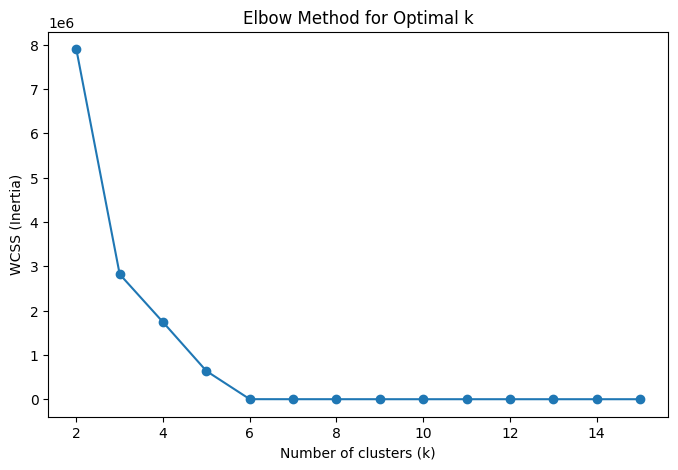

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 좌표 데이터 준비 (예시)
coords = df[['lat','lng']].dropna().to_numpy()

# 1~15까지 군집 수에 대해 inertia(WCSS) 계산
inertias = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# 그래프
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

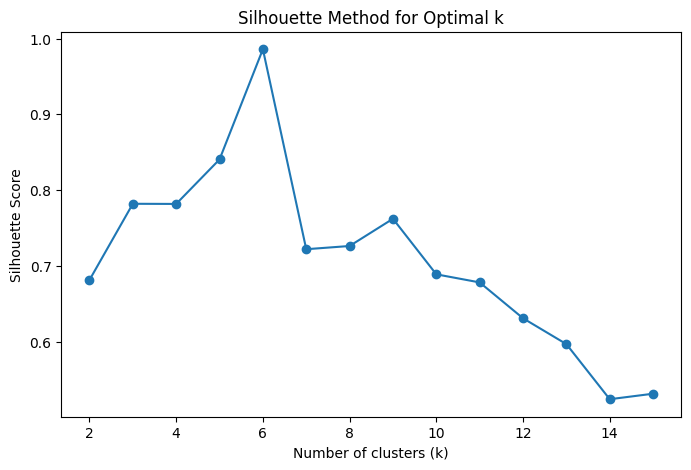

In [7]:
from sklearn.metrics import silhouette_score
import numpy as np

sample_size = 5000   # 데이터 많을 때 5천~1만개 정도만 뽑아도 충분
rng = np.random.default_rng(42)
coords_sample = coords[rng.choice(len(coords), size=sample_size, replace=False)]

sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(coords_sample)
    score = silhouette_score(coords_sample, labels)
    sil_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

- 엘보우 그래프: 기울기가 확 꺾이는 지점 = 후보 k
- 실루엣 그래프: 점수가 가장 높은 k = 추천 k

이때 데이터 크기가 커서 샘플링으로 데이터 뽑아서 실루엣 진행함

1. 엘보우 > k=5~8부근에서 꺾임
2. 실루엣 > k=6~7일때 최고점 1에 가까움

최적의 k=6로 설정


In [8]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
df_region['Region'] = kmeans.fit_predict(df_region[['lat','lng']])

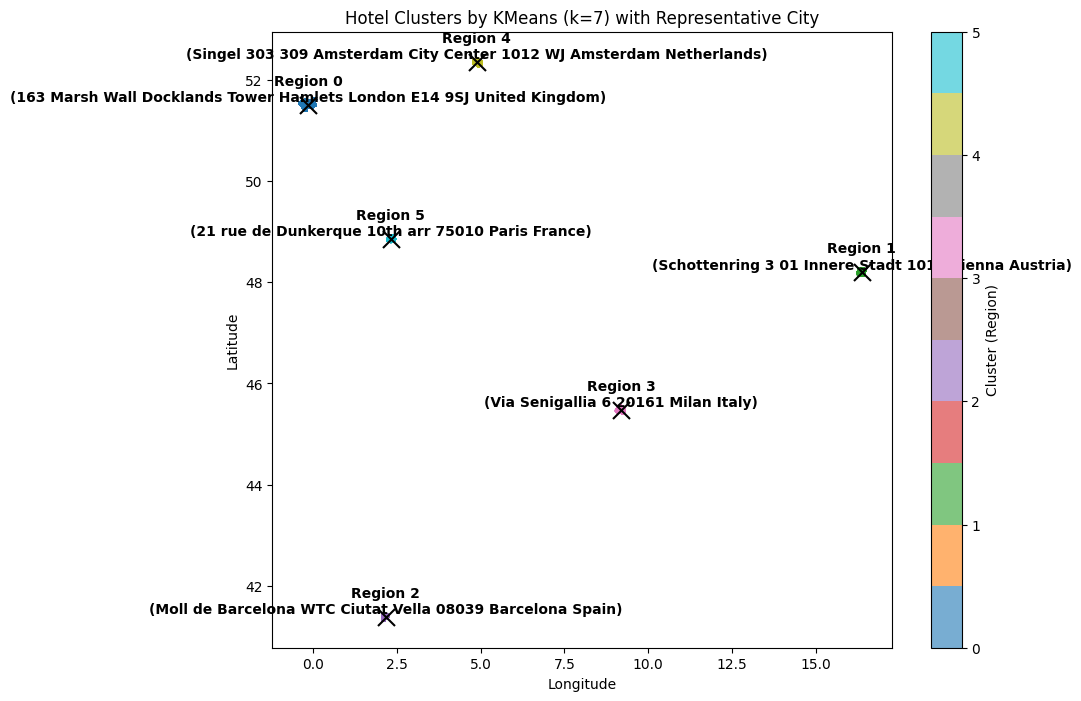

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# 1. 주소에서 도시명 추출 함수
def extract_city(addr: str) -> str:
    if not isinstance(addr, str):
        return None
    parts = [p.strip() for p in addr.split(',') if p.strip()]
    if len(parts) >= 2:
        return parts[-2]  # 보통 "..., City, Country"
    return parts[-1] if parts else None

df_region['City'] = df_region['Hotel_Address'].apply(extract_city)

# 2. 군집별 대표 도시 구하기 (가장 많이 등장한 도시)
rep_city_by_cluster = (
    df_region.groupby('Region')['City']
             .apply(lambda x: Counter(x.dropna()).most_common(1)[0][0]
                    if len(x.dropna())>0 else f"Region_{x.name}")
             .to_dict()
)

# 3. 시각화
plt.figure(figsize=(10,8))
scatter = plt.scatter(
    df_region['lng'], df_region['lat'],
    c=df_region['Region'], cmap='tab10', s=5, alpha=0.6
)

# 4. 군집 중심 표시 + 대표 도시 라벨
centers = kmeans.cluster_centers_
for idx, (lat, lng) in enumerate(centers):
    plt.scatter(lng, lat, c='black', s=150, marker='x')  # 중심점
    label = f"Region {idx}\n({rep_city_by_cluster.get(idx,'N/A')})"
    plt.text(lng, lat, label, fontsize=10, fontweight='bold',
             ha='center', va='bottom', color='black')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hotel Clusters by KMeans (k=7) with Representative City")
plt.colorbar(scatter, label="Cluster (Region)")
plt.show()


## 전처리

2. Reviewer_Nationality에서 리뷰 수가 많은 상위 N개 국적만 남기고 나머지는 Other로 묶음

In [10]:
df_region['Reviewer_Nationality'].value_counts()

,count
Reviewer_Nationality,
United Kingdom,244457
United States of America,35196
Australia,21540
Ireland,14746
United Arab Emirates,10176
...,...
Cape Verde,1
Northern Mariana Islands,1
Tuvalu,1


In [11]:
# 2. 국적 상위 N개만 남기고 나머지는 other로 분류
# 소수집단 버리지 않고 노이즈 줄임
top_n = df_region['Reviewer_Nationality'].value_counts().head(10).index
df_region['Nationality_Group'] = df_region['Reviewer_Nationality'].apply(
    lambda x: x if x in top_n else 'Other'
)

## 전처리

3. 교호작용 효과를 확인하기 위한 (Region × Reviewer_Nationality) 교차집단 만들기

<Axes: xlabel='Region', ylabel='Nationality_Group'>

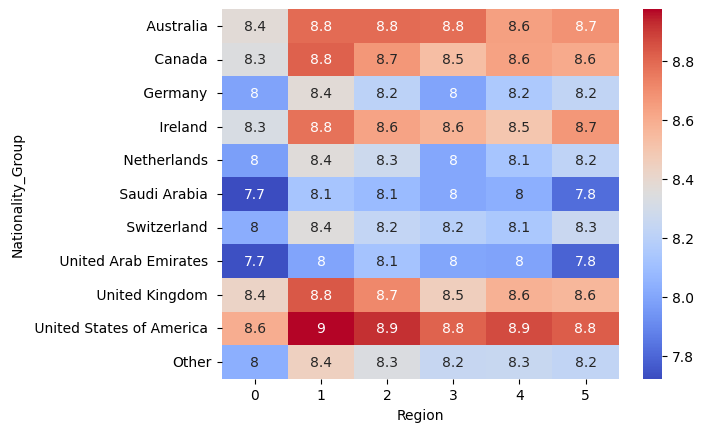

In [12]:
# 3. 그룹별 평균 평점
# 지역x국적 조합별로 평균평점과 표본 수 구함 > .agg 함수 이용
grouped = df_region.groupby(['Region','Nationality_Group'])['Reviewer_Score'].agg(['mean','count']).reset_index()
# 표본이 너무 적으면 가짜 패턴 발생할 수 있으니 최소 표본 수(30이상으로) 필터걸어줌
grouped_filtered = grouped[grouped['count'] >= 30]

# 4. 히트맵으로 시각화
import seaborn as sns
pivot = grouped_filtered.pivot(index='Nationality_Group', columns='Region', values='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

### 히트맵 결과 확인

```
  0: 'Amsterdam, Netherlands',
  1: 'London, United Kingdom',
  2: 'Paris, France',
  3: 'Barcelona, Spain',
  4: 'Milan, Italy',
  5: 'Vienna, Austria',
  6: 'Lisbon, Portugal'
```

1. 세로축: 리뷰어의 국적 / 가로축: 호텔이 위치한 도시
2. 셀색상: 평균 평점(숫자가 높을수록 진빨강, 낮을수록 진파랑)
3. 셀 안 숫자: 평균 폄점 실제 값

---

- 가로줄: 같은 국적 리뷰어가 여러 도시 호텔에 준 평점이 어떻게 다른지 확인가능
- 세로줄: 특정 도시 호텔이 국적에 따라 어떻게 평가되는지 확인가능
- 색상대비: 색 차이가 큰 행/열있으면 그 국적 또는 도시가 평점에 대해 편향이 있다는 것을 의미함

## 통계검정 > Two-way ANOVA

- 독립변수
    - 호텔위치(Region)
    - 리뷰어 국적(Nationality_Group)
- 종속변수: 리뷰평점(Reviewer_Score)

---

### 확인해 봐야 할 포인트

1. 위치 효과 (도시/지역별 평점 차이 존재 여부)
2. 국적 효과 (국적별 평점 차이 존재 여부)
3. 상호작용 효과 (특정 국적이 특정 위치에서 특히 다르게 평가하는가)

In [13]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 데이터 준비: Region, Reviewer_Nationality, Reviewer_Score 포함된 df_region
# 국적 상위 N개만 유지
top_n = df_region['Reviewer_Nationality'].value_counts().head(10).index
df_region['Nationality_Group'] = df_region['Reviewer_Nationality'].apply(
    lambda x: x if x in top_n else 'Other'
)

# 유효 데이터만
anova_df = df_region.dropna(subset=['Region','Reviewer_Score','Nationality_Group']).copy()

# 범주형으로 변환
anova_df['Region'] = anova_df['Region'].astype('category')
anova_df['Nationality_Group'] = anova_df['Nationality_Group'].astype('category')

# 이원분산분석 모델 (상호작용 포함)
model = smf.ols('Reviewer_Score ~ C(Region) * C(Nationality_Group)', data=anova_df).fit()
anova_table = anova_lm(model, typ=2)

print(anova_table)

                                      sum_sq        df           F  \
C(Region)                       7.992573e+03       5.0  608.187368   
C(Nationality_Group)            2.365671e+04      10.0  900.067778   
C(Region):C(Nationality_Group)  6.008155e+02      50.0    4.571850   
Residual                        1.346765e+06  512404.0         NaN   

                                      PR(>F)  
C(Region)                       0.000000e+00  
C(Nationality_Group)            0.000000e+00  
C(Region):C(Nationality_Group)  1.174572e-24  
Residual                                 NaN  


### ANOVA 결과

- C(Region) 유의 → 호텔 위치(군집/도시)에 따라 평균 평점 차이가 있음
- C(NatGroup) 유의 → 국적 그룹에 따라 평균 평점 차이가 있음
- C(Region):C(NatGroup) 유의 → 특정 국적이 특정 지역에서 특별히 다르게 평가함 (상호작용 존재)

---
## 머신러닝 구동

1. 회귀모델 -> 평점이 얼마나 정확히 예측되는가?
2. 분류모델 -> 국적x위치 조합으로 평점 고/저를 얼마나 맞출 수 있는가?

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 입력/출력
X = df_region[['Region','Nationality_Group']]
y = df_region['Reviewer_Score']

# 전처리: 범주형 One-Hot
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region','Nationality_Group'])
])

# 모델
reg_model = Pipeline([
    ('preprocess', preprocess),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 학습
reg_model.fit(X_train, y_train)

# 예측 & 평가
y_pred = reg_model.predict(X_test)
print("회귀 성능 (평점 예측)")
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


회귀 성능 (평점 예측)
R²: 0.021274334830213237
RMSE: 2.6461885050956964


### 회귀 분석 결과

- R²: 0.021274334830213237
    - 위치x국적이 평점을 얼마나 설명하는지 > 설명력이 낮음(낮을수밖에)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# 라벨링: 8점 이상 긍정=1, 7점 이하=0
df_region['HighScore'] = (df_region['Reviewer_Score'] >= 8).astype(int)

X = df_region[['Region','Nationality_Group']]
y = df_region['HighScore']

# 전처리: 범주형 원핫
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region','Nationality_Group'])
])

clf_model = Pipeline([
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_model.fit(X_train, y_train)

y_pred = clf_model.predict(X_test)
print("분류 성능 (긍정/부정 예측)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


분류 성능 (긍정/부정 예측)
Accuracy: 0.651589361328468
F1: 0.7880687011121794


### 분류모델 결과 확인

- Accuracy: 0.651589361328468
    - 단순 위치.국적 정보만으로 긍정/부정 맞추긴 하는데.. 애매함 더 올리자!

--------

## 나라별 호텔위치 k-means 진행 <조장님 피드백 반영> 확인해보기

### 1. 국가별 호텔의 개수 확인

In [16]:
# 주소에서 국가 추출 (맨 마지막 단어)
def extract_country(addr: str) -> str:
    if not isinstance(addr, str):
        return None
    parts = [p.strip() for p in addr.split(',') if p.strip()]
    country = parts[-1] if parts else None
    # 국가명은 마지막 토큰에서 공백 기준으로 마지막 단어
    if country:
        country = country.split()[-1]
    return country

df['Country'] = df['Hotel_Address'].apply(extract_country)

# 호텔별 중복 제거 후 국가별 호텔 개수 집계
hotel_country_counts = (
    df.drop_duplicates(subset=['Hotel_Name'])
      .groupby('Country')['Hotel_Name']
      .count()
      .reset_index(name='Hotel_Count')
      .sort_values('Hotel_Count', ascending=False)
      .reset_index(drop=True)
)

print(hotel_country_counts.head(10))

       Country  Hotel_Count
0       France          458
1      Kingdom          400
2        Spain          211
3        Italy          161
4      Austria          157
5  Netherlands          105


In [17]:
hotel_country_counts['Country']

,Country
0,France
1,Kingdom
2,Spain
3,Italy
4,Austria
5,Netherlands


## 결과 정리

1. 데이터 내 호텔의 갯수가 프랑스 > 영국 > 스페인 순으로 많음을 확인함
2. 우선 프랑스를 중점적으로 호텔 군집화 후 프랑스 내 리뷰어의 평점 확인할 것!

### 프랑스 호텔에 리뷰남긴 리뷰어 국적 수 확인

[France] 호텔 리뷰 작성자 국적 분포 (상위 10개):
         Reviewer_Nationality  Review_Count  Share_%  Cumulative_%
0             United Kingdom          16908    28.21         28.21
1   United States of America           7279    12.15         40.36
2                  Australia           3904     6.51         46.87
3               Saudi Arabia           1994     3.33         50.20
4                     France           1860     3.10         53.30
5       United Arab Emirates           1539     2.57         55.87
6                Netherlands           1485     2.48         58.35
7                     Canada           1335     2.23         60.58
8                    Ireland           1327     2.21         62.79
9                    Germany           1245     2.08         64.87


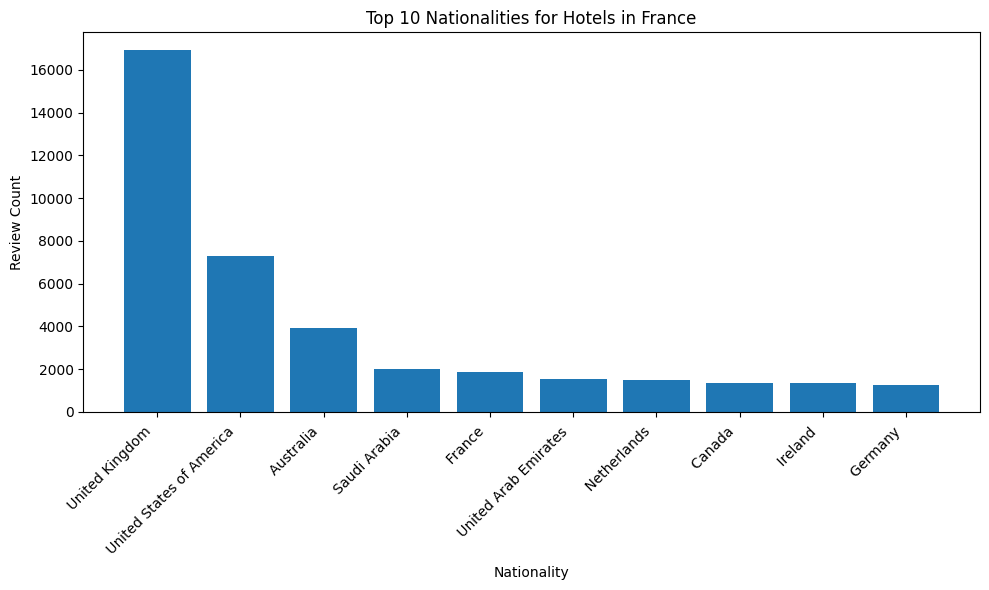

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def extract_country_suffix(address: str) -> str | None:
    """주소 문자열 끝에서 국가명을 안정적으로 추출 (긴 이름부터 매칭)."""
    if not isinstance(address, str):
        return None
    a = address.strip()
    # 긴 이름을 우선 비교
    for c in sorted(hotel_country_counts['Country'], key=len, reverse=True):
        if a.endswith(c):
            return c
    # 그래도 못 찾으면 마지막 콤마 구분 토큰을 fallback으로 사용
    parts = [p.strip() for p in a.split(",") if p.strip()]
    if parts:
        return parts[-1]
    return None

fr = df[df["Country"] == 'France'].copy()

# =========================
# 3) 국적별 리뷰 수/비율 집계
# =========================
nat_counts = (
    fr.groupby("Reviewer_Nationality")
      .size()
      .reset_index(name="Review_Count")
      .sort_values("Review_Count", ascending=False)
      .reset_index(drop=True)
)

total = nat_counts["Review_Count"].sum()
nat_counts["Share_%"] = (nat_counts["Review_Count"] / total * 100).round(2)
nat_counts["Cumulative_%"] = nat_counts["Share_%"].cumsum().round(2)

print(f"[{'France'}] 호텔 리뷰 작성자 국적 분포 (상위 10개):")
print(nat_counts.head(10))


# =========================
# 4) 상위 N개 바 차트 (선택)
# =========================
top = nat_counts.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top["Reviewer_Nationality"], top["Review_Count"])  # 색상 지정 안 함(기본값)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Nationality")
plt.ylabel("Review Count")
plt.title(f"Top {10} Nationalities for Hotels in {'France'}")
plt.tight_layout()
plt.show()


## 프랑스 내 리뷰어의 국적확인 결과 정리

1. 근접국인 영국이 압도적으로 많은 리뷰를 남김
2. 이후로 미국, 호주, 사우디 순으로 많음
3. 같은 국가인 프랑스는 생각보다 높지는 않았음! > 우선 영국이 가장 많은 것으로 확인


---

### 프랑스 내 호텔 군집화 해보기

추천 k(실루엣·샘플기준): 5


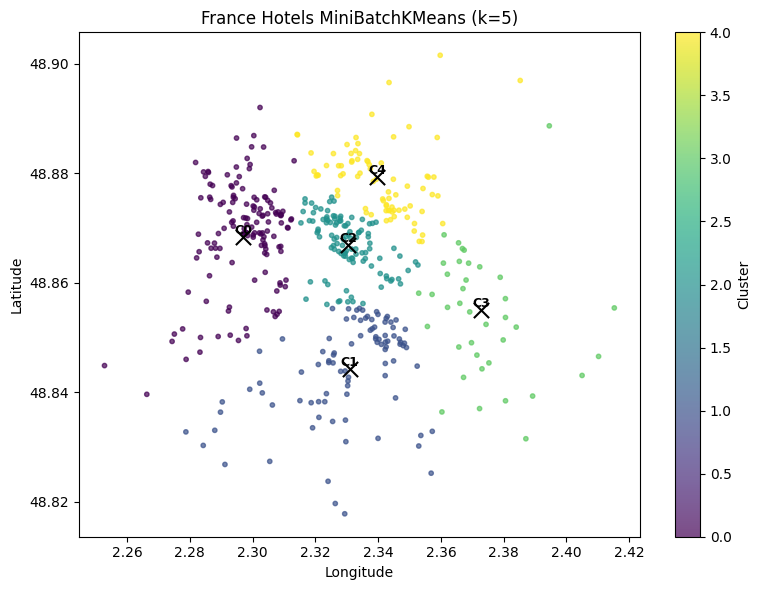

In [19]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


# 1) 필요한 컬럼만 읽어서 메모리 절약
usecols = ["Hotel_Name","Hotel_Address","lat","lng"]

# 3) 프랑스만 + 좌표 결측 제거 + 고유 호텔만
fr_hotels = (
    df[df["Country"]=="France"]
      .dropna(subset=["lat","lng"])
      .drop_duplicates(subset=["Hotel_Name"])  # 호텔 단위
      .reset_index(drop=True)
)

if len(fr_hotels) < 2:
    raise ValueError("프랑스 호텔 표본이 너무 적어요.")

# 4) 경도 보정(프랑스 한정): lng * cos(mean_lat)
lat = fr_hotels["lat"].to_numpy()
lng = fr_hotels["lng"].to_numpy()
lng_adj = lng * np.cos(np.deg2rad(lat.mean()))
X = np.column_stack([lat, lng_adj])

# 5) 샘플링(속도용) + k 후보 평가
sample_n = min(len(X), 8000)                # 8천 정도면 충분히 빠름
idx = np.random.default_rng(42).choice(len(X), size=sample_n, replace=False)
Xs = X[idx]

K_range = range(3, 10)                      # 3~9개 후보
sil_scores = []
for k in K_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, max_iter=100, n_init=5)
    labels = mbk.fit_predict(Xs)
    if len(np.unique(labels)) > 1:
        sil_scores.append(silhouette_score(Xs, labels))
    else:
        sil_scores.append(-1)

best_k = K_range[int(np.argmax(sil_scores))]
print("추천 k(실루엣·샘플기준):", best_k)

# 6) 전체 호텔에 best_k로 학습 + 라벨 부여
final_mbk = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=4096, max_iter=200, n_init=5)
fr_hotels["Cluster"] = final_mbk.fit_predict(X)

# 7) 시각화(표본만 찍기)
plot_n = min(len(fr_hotels), 30000)
plot_df = fr_hotels.sample(plot_n, random_state=42) if len(fr_hotels)>plot_n else fr_hotels

plt.figure(figsize=(8,6))
sc = plt.scatter(plot_df["lng"], plot_df["lat"], c=plot_df["Cluster"], s=10, alpha=0.7)
# 중심 (경도 역보정)
centers_lat, centers_lng_adj = final_mbk.cluster_centers_[:,0], final_mbk.cluster_centers_[:,1]
centers_lng = centers_lng_adj / np.cos(np.deg2rad(lat.mean()))
for i, (clat, clng) in enumerate(zip(centers_lat, centers_lng)):
    plt.scatter(clng, clat, c='black', s=120, marker='x')
    plt.text(clng, clat, f"C{i}", ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"France Hotels MiniBatchKMeans (k={best_k})")
plt.colorbar(sc, label="Cluster")
plt.tight_layout(); plt.show()


## 프랑스 내 호텔의 군집화 결과 정리

1. 실루엣,엘보우 결과 최적의 k=5로 정해짐
2. 표본의 수가 너무 많아서 데이터 샘플링을 통해 정해진 k임을 짚고 넘어가야함
3. 코드에서 country 명만 원하는 국가로 바꾸면 검색 가능


```
COUNTRIES = [
    "United Kingdom","United States of America","Netherlands","France","Spain","Italy",
    "Austria","Portugal","Germany","Belgium","Switzerland","Ireland","Denmark","Sweden",
    "Norway","Finland","Iceland","Czech Republic","Poland","Hungary","Greece",
    "Turkey","Russia","Ukraine","Romania","Bulgaria","Croatia","Slovenia","Slovakia",
    "Serbia","Bosnia and Herzegovina","Montenegro","North Macedonia","Albania",
    "Luxembourg","Liechtenstein","Monaco","Andorra","San Marino","Vatican City"
]
```

1. 원하는 국가명을 `df[df["Country"]=="France"]`안에 넣으시오
2. usecols = ["Hotel_Name","Hotel_Address","lat","lng"] 요 애들로만 샘플링한 것임!


---

## 프랑스 군집 내 도시 분포 확인

- 군집 별로 어느도시인지 확인하는 코드

In [20]:
from collections import Counter

# 주소에서 "도시" 추출 (보통 형식: "... , City, Country")
def extract_city(addr: str):
    if not isinstance(addr, str):
        return None
    parts = [p.strip() for p in addr.split(",") if p.strip()]
    if len(parts) >= 2:
        return parts[-2]   # 마지막에서 두 번째가 도시일 가능성 높음
    return parts[-1] if parts else None

# 프랑스 호텔 데이터프레임에 City 컬럼 추가
fr_hotels["City"] = fr_hotels["Hotel_Address"].apply(extract_city)

# 군집별 대표 도시 Top-5 뽑기
rep_cities = (
    fr_hotels.groupby("Cluster")["City"]
    .apply(lambda s: ", ".join([f"{c}({n})" for c,n in Counter(s).most_common(5)]))
    .reset_index(name="Top_Cities")
)

# 군집 요약 (호텔 수 + 대표 도시들)
summary = (
    fr_hotels.groupby("Cluster")
    .agg(Hotel_Count=("Hotel_Name","nunique"))
    .reset_index()
    .merge(rep_cities, on="Cluster", how="left")
    .sort_values("Cluster", ascending=True)
)
pd.set_option("display.max_colwidth", None)
print(summary)


   Cluster  Hotel_Count  \
0        0          139   
1        1           93   
2        2          107   
3        3           38   
4        4           78   

                                                                                                                                                                                                                                                                     Top_Cities  
0                     1 3 Rue d Argentine 16th arr 75116 Paris France(1), 1 Avenue Carnot 17th arr 75017 Paris France(1), 10 12 rue Cognacq Jay 7th arr 75007 Paris France(1), 10 avenue Carnot 17th arr 75017 Paris France(1), 10 Avenue D I na 16th arr 75016 Paris France(1)  
1  1 Bis Rue De Vaugirard 6th arr 75006 Paris France(1), 1 Place De La Sorbonne 5th arr 75005 Paris France(1), 10 rue de Vaugirard 6th arr 75006 Paris France(1), 10 rue Gager Gabillot 15th arr 75015 Paris France(1), 11 Bis Rue Jules Chaplain 6th arr 75006 Paris France(1)  
2              

In [21]:
fr_hotels["City"].value_counts().head(5)

,count
City,
Place de l Op ra 4 rue Meyerbeer 9th arr 75009 Paris France,1
1 3 Rue d Argentine 16th arr 75116 Paris France,1
1 5 Passage Ruelle 18th arr 75018 Paris France,1
1 Avenue Carnot 17th arr 75017 Paris France,1
1 Bis Rue De Vaugirard 6th arr 75006 Paris France,1


## 프랑스 호텔 군집화 한 결과 확인

1. 이상하다 싶어서 확인해보니 프랑스에 리뷰가 담긴 8~90%는 파리임
2. 나머지 소도시의 리뷰는 거의 극소수여서 파리위주로 군집화 된 것!
3. 나라 별 도시 특성 상 어쩔수 없는 결과 > 당연한 것이라고 생각이 듦!

> 일단 저 군집화 되어 나온 대표 도시 구글맵 다 찍어서 확인해본 결과 파리 내 호텔들임

## 군집 별 요약 통계 확인
 - 각 군집별로 리뷰어들의 평균 평점이 어느정도인지 박스플롯으로 확인
 - 박스 내 평균 평점 확인 가능
 - 박스 크기를 통해 리뷰의 편차 확인 가능

   Cluster  count      mean       std  min   max
2        2    107  8.481308  1.802939  3.3  10.0
1        1     93  8.373118  1.682980  3.8  10.0
3        3     38  8.352632  1.733102  4.2  10.0
0        0    139  8.083453  1.935803  2.5  10.0
4        4     78  8.061538  1.727864  3.3  10.0


/tmp/ipython-input-2803209541.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Reviewer_Score", data=fr_hotels, palette="Set2")


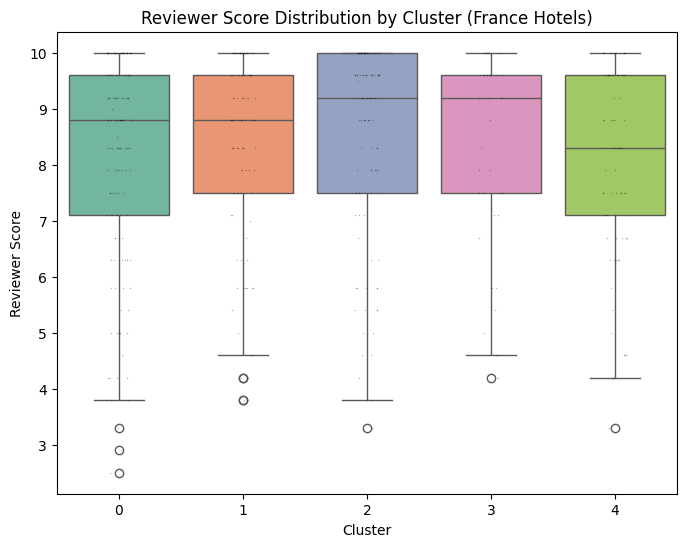

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 군집별 평점 요약 통계
score_summary = (
    fr_hotels.groupby("Cluster")["Reviewer_Score"]
    .agg(["count","mean","std","min","max"])
    .reset_index()
    .sort_values("mean", ascending=False)
)
print(score_summary)

# 박스플롯 시각화
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Reviewer_Score", data=fr_hotels, palette="Set2")
sns.stripplot(x="Cluster", y="Reviewer_Score", data=fr_hotels,
              color="black", size=1, alpha=0.3)  # 분포 점찍기
plt.title("Reviewer Score Distribution by Cluster (France Hotels)")
plt.ylabel("Reviewer Score")
plt.show()


## 박스플롯 확인 결과 정리

1. 군집 2의 평균 점수가 더 높음 / 군집 4의 평균 제일 낮음
2. 군집 1,3의 편차가 제일 작아보임
3. 그러나 1보다 3의 평균 점수가 더 높음

## 프랑스 호텔의 리뷰어의 국가 별 평점 분포 > 요약통계 & 박스플롯

1. 요약통계를 통해 프랑스 호텔에 각 국가의 리뷰어들의 평균 평점과 표준편차, 최소&최대 평점 확인 가능
2. 박스플롯 통해 위 수치들을 시각적으로 확인 가능

          Reviewer_Nationality  count      mean       std  min   max
55             United Kingdom     120  8.287500  1.757699  3.3  10.0
56   United States of America      87  8.826437  1.528524  3.8  10.0
1                   Australia      43  8.488372  1.763547  3.3  10.0
54       United Arab Emirates      13  7.453846  2.197959  3.8  10.0
35                Netherlands      12  6.916667  2.260263  3.3  10.0
44               Saudi Arabia      11  7.245455  2.029957  2.9  10.0
8                      Canada      11  8.318182  1.850307  5.0  10.0
17                    Germany      10  7.550000  1.965395  5.0  10.0
16                     France      10  8.050000  1.786524  5.0  10.0
3                     Belgium       8  8.075000  1.719427  4.6  10.0


/tmp/ipython-input-2952320611.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Reviewer_Nationality", y="Reviewer_Score",


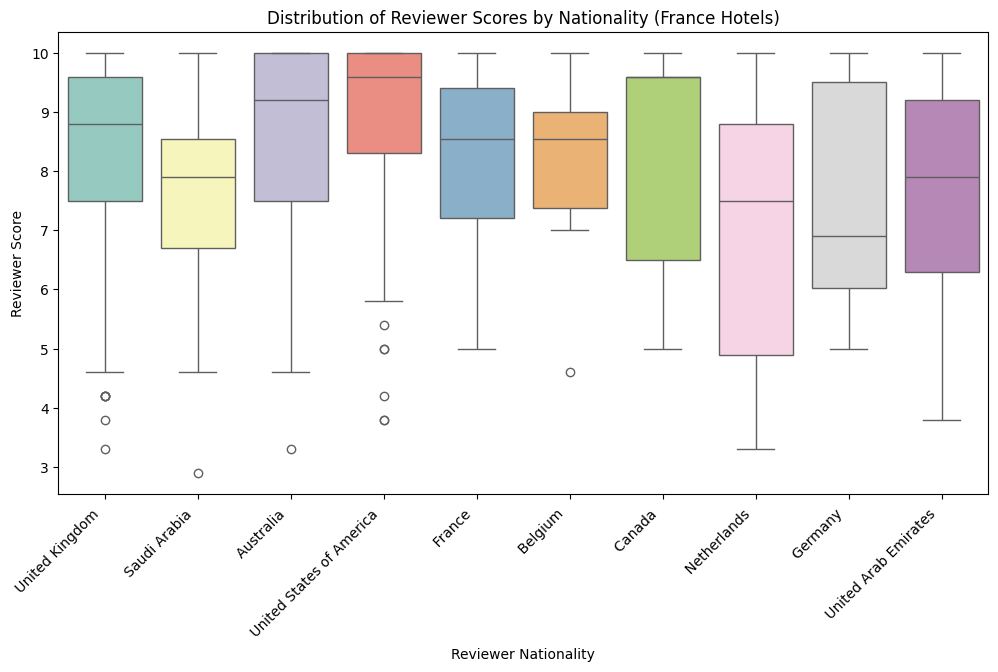

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 리뷰어 국적별 요약 통계
nation_summary = (
    fr_hotels.groupby("Reviewer_Nationality")["Reviewer_Score"]
    .agg(["count","mean","std","min","max"])
    .reset_index()
    .sort_values("count", ascending=False)
)

print(nation_summary.head(10))  # 리뷰 많은 상위 10개 국적

# 2) 상위 국적별 분포 시각화 (상위 10개만 예시)
top_nations = nation_summary.head(10)["Reviewer_Nationality"]

plt.figure(figsize=(12,6))
sns.boxplot(x="Reviewer_Nationality", y="Reviewer_Score",
            data=fr_hotels[fr_hotels["Reviewer_Nationality"].isin(top_nations)],
            palette="Set3")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Reviewer Scores by Nationality (France Hotels)")
plt.ylabel("Reviewer Score")
plt.xlabel("Reviewer Nationality")
plt.show()


## 박스플롯 결과 정리

1. 미국 > 호주 > 영국 순으로 평점은 높은 수준
2. 네덜란드의 평점 분포가 제일 높음
3. 독일의 리뷰 평점이 제일 낮음

## 군집 0에 대한 국가별 평점 요약통계

In [24]:
# 군집 × 국적별 리뷰 통계 요약
cluster_nation_summary = (
    fr_hotels.groupby(["Cluster","Reviewer_Nationality"])["Reviewer_Score"]
    .agg(
        count="size",        # 리뷰 수
        mean="mean",         # 평균 점수
        std="std"            # 표준편차
    )
    .reset_index()
    .sort_values(["Cluster","count"], ascending=[True,False])
)

# 👉 원하는 군집만 필터링 (예: 군집 0)
cluster_id = 4
cluster_subset = cluster_nation_summary.query("Cluster == @cluster_id")

# 리뷰가 많은 순 상위 20개 출력
print(cluster_subset.head(20))


     Cluster        Reviewer_Nationality  count      mean       std
139        4             United Kingdom      28  7.814286  1.731990
116        4                  Australia       8  8.225000  1.788655
120        4                     Canada       6  8.633333  1.664532
124        4                    Germany       5  8.020000  1.639207
140        4   United States of America       5  9.680000  0.334664
129        4                Netherlands       4  6.475000  2.012254
118        4                    Belgium       2  6.700000  2.969848
123        4                     France       2  8.550000  0.353553
127        4                    Ireland       2  9.600000  0.000000
117        4                    Bahrain       1  9.600000       NaN
119        4                     Brazil       1  6.300000       NaN
121        4                      China       1  8.300000       NaN
122        4             Czech Republic       1  9.600000       NaN
125        4                    Iceland       1 

## 군집 0에 대한 국가별 평점 박스플롯

/tmp/ipython-input-741548812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


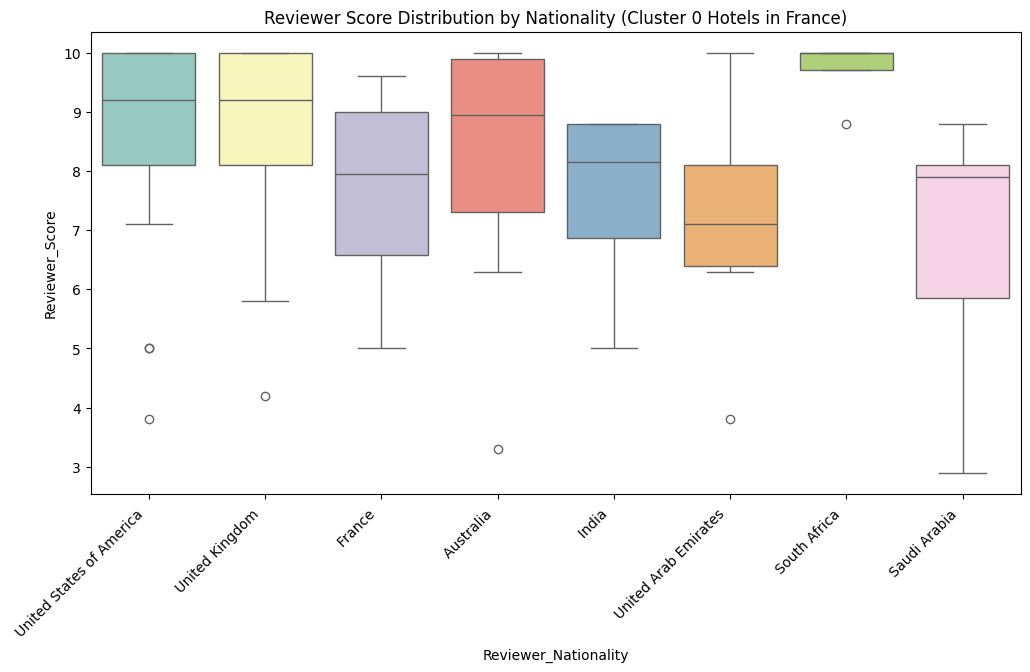

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예: Cluster 0의 상위 8개 국적
top_nations_c0 = (
    fr_hotels[fr_hotels["Cluster"]==0]["Reviewer_Nationality"]
    .value_counts().head(8).index
)

plt.figure(figsize=(12,6))
sns.boxplot(
    x="Reviewer_Nationality", y="Reviewer_Score",
    data=fr_hotels[(fr_hotels["Cluster"]==0) &
                   (fr_hotels["Reviewer_Nationality"].isin(top_nations_c0))],
    palette="Set3"
)
plt.title("Reviewer Score Distribution by Nationality (Cluster 0 Hotels in France)")
plt.xticks(rotation=45, ha="right")
plt.show()


## 군집 별 리뷰어 국가 별 평점 히트맵

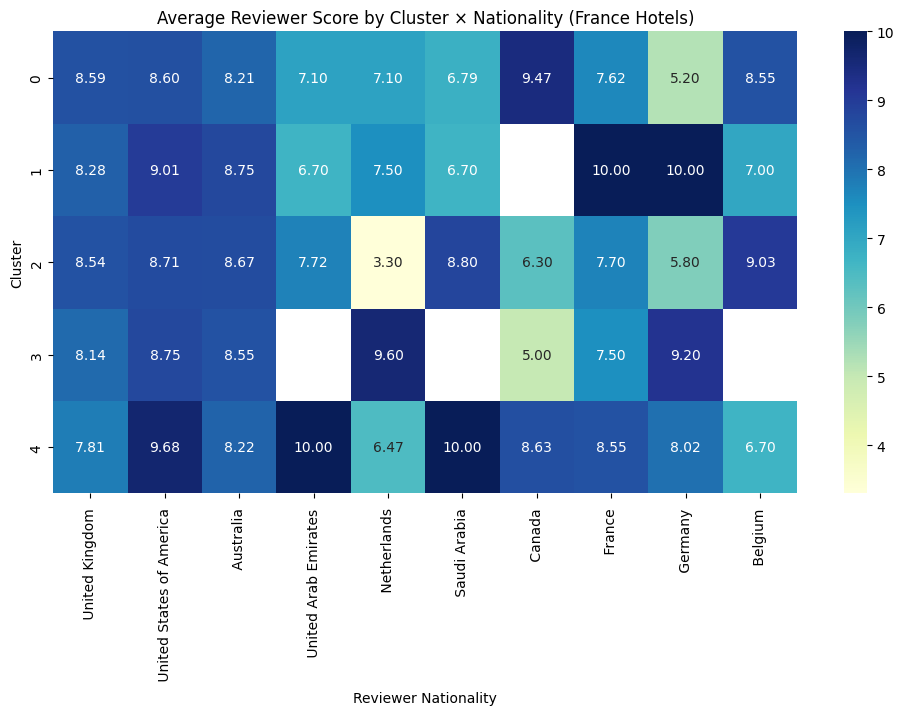

In [26]:
# 군집 × 국적 pivot
pivot_table = (
    fr_hotels.groupby(["Cluster","Reviewer_Nationality"])["Reviewer_Score"]
    .mean().unstack(fill_value=np.nan)
)

# 리뷰 많은 국적만 남기기 (상위 10개 예시)
top_reviewers = fr_hotels["Reviewer_Nationality"].value_counts().head(10).index
pivot_table = pivot_table[top_reviewers]

plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Reviewer Score by Cluster × Nationality (France Hotels)")
plt.ylabel("Cluster")
plt.xlabel("Reviewer Nationality")
plt.show()


In [27]:
import pandas as pd

# (선택) Country 컬럼이 없다면 주소 끝에서 국가를 추출해서 생성
def extract_country(addr: str):
    if not isinstance(addr, str):
        return None
    parts = [p.strip() for p in addr.split(",") if p.strip()]
    return parts[-1] if parts else None

if "Country" not in df.columns:
    df["Country"] = df["Hotel_Address"].apply(extract_country)

# 1) 프랑스 전체 리뷰
fr = df[df["Country"] == "France"].copy()
total_fr_reviews = len(fr)

# 2) 프랑스 내 '영국 국적' 리뷰 필터 (공백/대소문자 안전)
uk_mask = fr["Reviewer_Nationality"].astype(str).str.strip().str.lower() == "united kingdom"
uk_fr = fr[uk_mask].copy()
uk_review_count = len(uk_fr)

# 3) 영국 리뷰의 긍/부정 포함 여부
pos_mask = uk_fr["Positive_Review"].astype(str).str.strip().str.lower() != "no positive"
neg_mask = uk_fr["Negative_Review"].astype(str).str.strip().str.lower() != "no negative"

pos_count = int(pos_mask.sum())
neg_count = int(neg_mask.sum())

# 0 나누기 방지
if uk_review_count > 0:
    pos_ratio = round(pos_count / uk_review_count * 100, 2)
    neg_ratio = round(neg_count / uk_review_count * 100, 2)
else:
    pos_ratio = neg_ratio = 0.0

# 4) 결과 출력
print("=== France Reviews Summary ===")
print(f"- 프랑스 전체 리뷰 수: {total_fr_reviews}")
print(f"- 프랑스 내 영국 국적 리뷰 수: {uk_review_count}")

print("\n=== 영국 국적 리뷰의 긍/부정 포함 비율 ===")
print(f"- 긍정 포함(Positive_Review 텍스트 존재): {pos_count}개 ({pos_ratio}%)")
print(f"- 부정 포함(Negative_Review 텍스트 존재): {neg_count}개 ({neg_ratio}%)")

# (선택) 표 형태로도 보기
summary_df = pd.DataFrame({
    "Metric": ["Total_FR_Reviews", "UK_in_FR_Reviews", "UK_Positive_Count", "UK_Negative_Count", "UK_Positive_%", "UK_Negative_%"],
    "Value":  [total_fr_reviews, uk_review_count, pos_count, neg_count, pos_ratio, neg_ratio]
})
print("\n--- Table ---")
print(summary_df)


=== France Reviews Summary ===
- 프랑스 전체 리뷰 수: 59928
- 프랑스 내 영국 국적 리뷰 수: 16908

=== 영국 국적 리뷰의 긍/부정 포함 비율 ===
- 긍정 포함(Positive_Review 텍스트 존재): 16068개 (95.03%)
- 부정 포함(Negative_Review 텍스트 존재): 12262개 (72.52%)

--- Table ---
              Metric     Value
0   Total_FR_Reviews  59928.00
1   UK_in_FR_Reviews  16908.00
2  UK_Positive_Count  16068.00
3  UK_Negative_Count  12262.00
4      UK_Positive_%     95.03
5      UK_Negative_%     72.52


In [28]:
score_summary = (
    fr_hotels.dropna(subset=["Cluster","Reviewer_Score"])
             .groupby("Cluster")["Reviewer_Score"]
             .agg(count="size", mean="mean", std="std", min="min", max="max")
             .reset_index()
             .sort_values("Cluster")
)
print("=== 군집별 리뷰 평점 요약 ===")
print(score_summary)

=== 군집별 리뷰 평점 요약 ===
   Cluster  count      mean       std  min   max
0        0    139  8.083453  1.935803  2.5  10.0
1        1     93  8.373118  1.682980  3.8  10.0
2        2    107  8.481308  1.802939  3.3  10.0
3        3     38  8.352632  1.733102  4.2  10.0
4        4     78  8.061538  1.727864  3.3  10.0


---

In [29]:
fr_hotels.groupby("Cluster")["Reviewer_Score"]

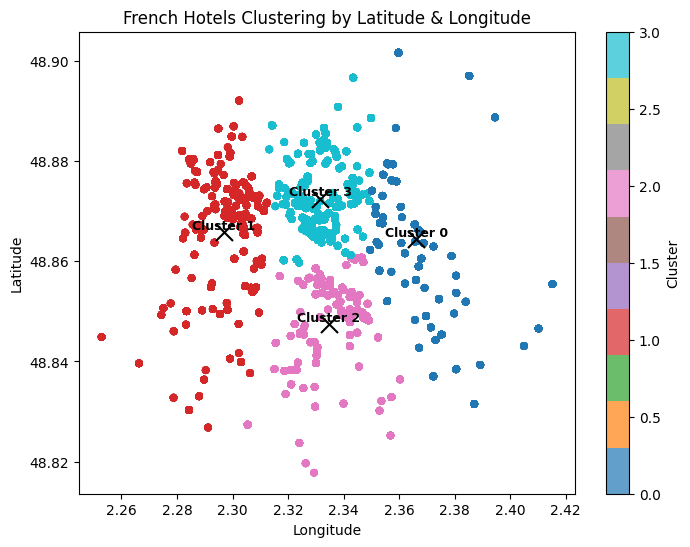

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

fr = df[df["Country"] == 'France'].copy()

df["Country"] = df["Hotel_Address"].apply(extract_country_suffix)
fr = df[df["Country"] == 'France'].dropna(subset=['lat','lng']).copy()

# 4. K-Means 군집화 (k=4 예시, elbow/silhouette로 최적 k 찾는 게 이상적)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
fr['Cluster'] = kmeans.fit_predict(fr[['lat','lng']])

# 5. 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    fr['lng'], fr['lat'],
    c=fr['Cluster'], cmap='tab10', s=20, alpha=0.7
)

# 군집 중심점 표시
centers = kmeans.cluster_centers_
for i, (lat, lng) in enumerate(centers):
    plt.scatter(lng, lat, c='black', marker='x', s=150)
    plt.text(lng, lat, f"Cluster {i}", ha='center', va='bottom',
             fontsize=9, fontweight='bold', color='black')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("French Hotels Clustering by Latitude & Longitude")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [31]:
from collections import Counter
import numpy as np
import pandas as pd

# 주소에서 "도시" 추출 (일반적으로 ... , City, Country 형식)
def extract_city(addr: str) -> str | None:
    if not isinstance(addr, str): return None
    parts = [p.strip() for p in addr.split(",") if p.strip()]
    if len(parts) >= 2:
        return parts[-2]
    return parts[-1] if parts else None

# 도시 컬럼 생성
fr["City"] = fr["Hotel_Address"].apply(extract_city)

# 1) 군집별 호텔 수(고유), 리뷰 수(행), 평균 좌표
summary = (
    fr.groupby("Cluster").agg(
        Hotel_Count=("Hotel_Name", "nunique"),   # 고유 호텔 수
        Row_Count=("Hotel_Name", "size"),        # 리뷰(행) 수
        Mean_Lat=("lat","mean"),
        Mean_Lng=("lng","mean")
    ).reset_index()
)

# 2) 군집별 대표 도시 Top-3
def top_cities(series, topk=3):
    vals = [x for x in series if isinstance(x, str)]
    if not vals:
        return "N/A"
    top = Counter(vals).most_common(topk)
    return ", ".join([f"{c}({n})" for c,n in top])

rep_cities = (
    fr.groupby("Cluster")["City"]
      .apply(lambda s: top_cities(s, topk=3))
      .reset_index()
      .rename(columns={"City":"Top_Cities"})
)

# 3) KMeans 중심좌표(centroid) 병합
centers = pd.DataFrame(kmeans.cluster_centers_, columns=["Centroid_Lat","Centroid_Lng"])
centers["Cluster"] = centers.index

# 4) 최종 요약 테이블
cluster_summary = (
    summary.merge(rep_cities, on="Cluster", how="left")
           .merge(centers, on="Cluster", how="left")
           .sort_values(["Hotel_Count","Row_Count"], ascending=False)
           .reset_index(drop=True)
)

print(cluster_summary)

   Cluster  Hotel_Count  Row_Count   Mean_Lat  Mean_Lng  \
0        3          151      17511  48.872505  2.331585   
1        1          150      19493  48.865781  2.296861   
2        2           97      12356  48.847446  2.334707   
3        0           57      10186  48.864385  2.366158   

                                                                                                                                                                                      Top_Cities  \
0                                        202 rue de Rivoli 1st arr 75001 Paris France(700), 35 Rue Caumartin 9th arr 75009 Paris France(383), 17 rue de l Arcade 8th arr 75008 Paris France(376)   
1  3 Place du G n ral Koenig 17th arr 75017 Paris France(874), 18 Avenue De Suffren Entr e au 22 rue Jean Rey 15th arr 75015 Paris France(846), 20 Rue Jean Rey 15th arr 75015 Paris France(771)   
2     40 Rue du Commandant Ren Mouchotte 14th arr 75014 Paris France(692), 8 Place Marguerite de Navarre 1st arr 750

----
## 영국

[Kingdom] 호텔 리뷰 작성자 국적 분포 (상위 10개):
         Reviewer_Nationality  Review_Count  Share_%  Cumulative_%
0             United Kingdom         170649    65.06         65.06
1   United States of America          11011     4.20         69.26
2                  Australia           8473     3.23         72.49
3                    Ireland           7020     2.68         75.17
4       United Arab Emirates           3864     1.47         76.64
5               Saudi Arabia           3202     1.22         77.86
6                Switzerland           2992     1.14         79.00
7                Netherlands           2737     1.04         80.04
8                     Canada           2718     1.04         81.08
9                     Kuwait           2397     0.91         81.99


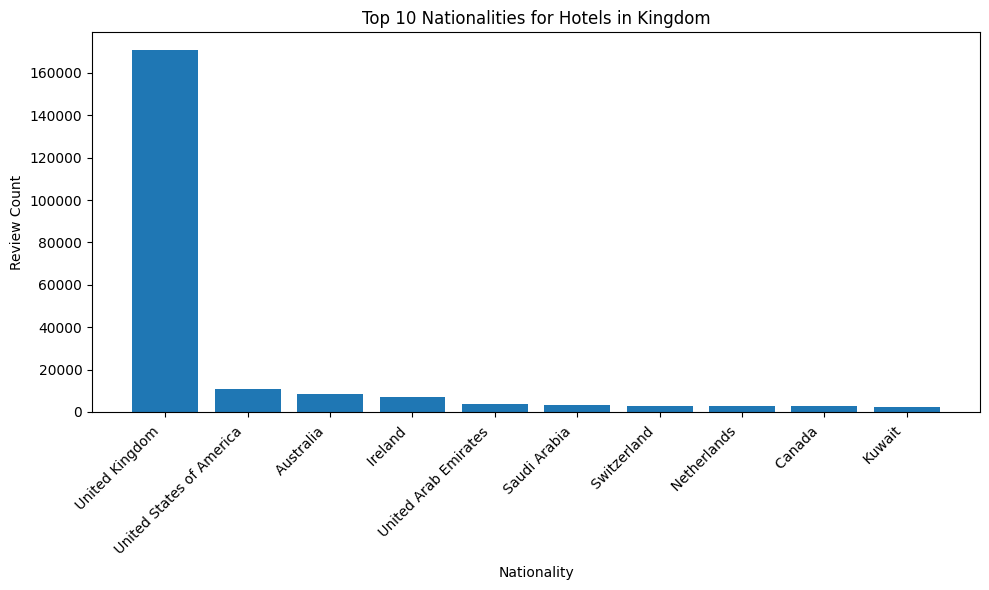

In [32]:
#영국 호텔에 리뷰남긴 리뷰어 국적 수
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def extract_country_suffix(address: str) -> str | None:
    """주소 문자열 끝에서 국가명을 안정적으로 추출 (긴 이름부터 매칭)."""
    if not isinstance(address, str):
        return None
    a = address.strip()
    # 긴 이름을 우선 비교
    for c in sorted(hotel_country_counts['Country'], key=len, reverse=True):
        if a.endswith(c):
            return c
    # 그래도 못 찾으면 마지막 콤마 구분 토큰을 fallback으로 사용
    parts = [p.strip() for p in a.split(",") if p.strip()]
    if parts:
        return parts[-1]
    return None

uk = df[df["Country"] == 'Kingdom'].copy()

# =========================
# 3) 국적별 리뷰 수/비율 집계
# =========================
nat_counts = (
    uk.groupby("Reviewer_Nationality")
      .size()
      .reset_index(name="Review_Count")
      .sort_values("Review_Count", ascending=False)
      .reset_index(drop=True)
)

total = nat_counts["Review_Count"].sum()
nat_counts["Share_%"] = (nat_counts["Review_Count"] / total * 100).round(2)
nat_counts["Cumulative_%"] = nat_counts["Share_%"].cumsum().round(2)

print(f"[{'Kingdom'}] 호텔 리뷰 작성자 국적 분포 (상위 10개):")
print(nat_counts.head(10))


# =========================
# 4) 상위 N개 바 차트 (선택)
# =========================
top = nat_counts.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top["Reviewer_Nationality"], top["Review_Count"])  # 색상 지정 안 함(기본값)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Nationality")
plt.ylabel("Review Count")
plt.title(f"Top {10} Nationalities for Hotels in {'Kingdom'}")
plt.tight_layout()
plt.show()

추천 k(실루엣·샘플기준): 9


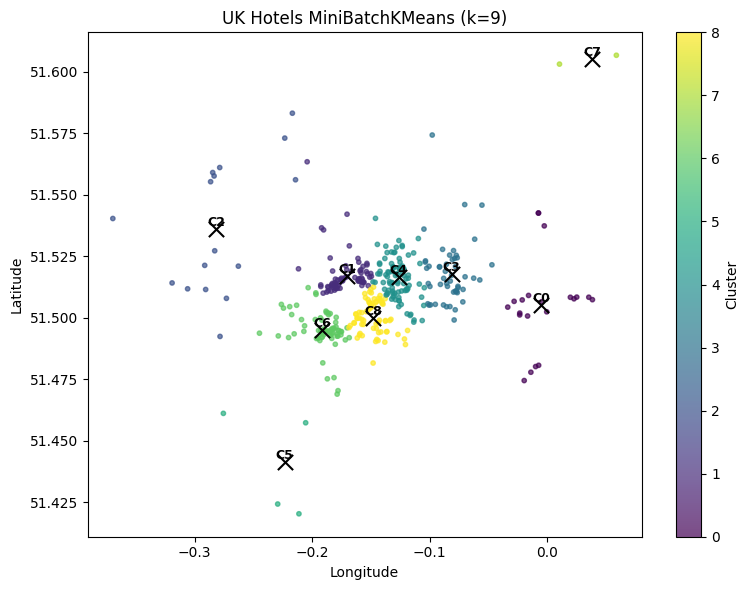

In [33]:
#영국 내 호텔 군집화
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


# 1) 필요한 컬럼만 읽어서 메모리 절약
usecols = ["Hotel_Name","Hotel_Address","lat","lng"]

# 3) 영국만 + 좌표 결측 제거 + 고유 호텔만
Uk_hotels = (
    df[df["Country"]=="Kingdom"]
      .dropna(subset=["lat","lng"])
      .drop_duplicates(subset=["Hotel_Name"])  # 호텔 단위
      .reset_index(drop=True)
)

if len(Uk_hotels) < 2:
    raise ValueError("영국 호텔 표본이 너무 적어요.")

# 4) 경도 보정(영국 한정): lng * cos(mean_lat)
lat = Uk_hotels["lat"].to_numpy()
lng = Uk_hotels["lng"].to_numpy()
lng_adj = lng * np.cos(np.deg2rad(lat.mean()))
X = np.column_stack([lat, lng_adj])

# 5) 샘플링(속도용) + k 후보 평가
sample_n = min(len(X), 8000)                # 8천 정도면 충분히 빠름
idx = np.random.default_rng(42).choice(len(X), size=sample_n, replace=False)
Xs = X[idx]

K_range = range(3, 10)                      # 3~9개 후보
sil_scores = []
for k in K_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, max_iter=100, n_init=5)
    labels = mbk.fit_predict(Xs)
    if len(np.unique(labels)) > 1:
        sil_scores.append(silhouette_score(Xs, labels))
    else:
        sil_scores.append(-1)

best_k = K_range[int(np.argmax(sil_scores))]
print("추천 k(실루엣·샘플기준):", best_k)

# 6) 전체 호텔에 best_k로 학습 + 라벨 부여
final_mbk = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=4096, max_iter=200, n_init=5)
Uk_hotels["Cluster"] = final_mbk.fit_predict(X)

# 7) 시각화(표본만 찍기)
plot_n = min(len(Uk_hotels), 30000)
plot_df = Uk_hotels.sample(plot_n, random_state=42) if len(Uk_hotels)>plot_n else Uk_hotels

plt.figure(figsize=(8,6))
sc = plt.scatter(plot_df["lng"], plot_df["lat"], c=plot_df["Cluster"], s=10, alpha=0.7)

# 중심 (경도 역보정)
centers_lat, centers_lng_adj = final_mbk.cluster_centers_[:,0], final_mbk.cluster_centers_[:,1]
centers_lng = centers_lng_adj / np.cos(np.deg2rad(lat.mean()))
for i, (clat, clng) in enumerate(zip(centers_lat, centers_lng)):
    plt.scatter(clng, clat, c='black', s=120, marker='x')
    plt.text(clng, clat, f"C{i}", ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"UK Hotels MiniBatchKMeans (k={best_k})")
plt.colorbar(sc, label="Cluster")
plt.tight_layout(); plt.show()

In [35]:
for i in range(9):
    print(f"--- Cluster {i} Hotels (Top 5) ---")

    # 해당 클러스터에 속하는 호텔 주소만 선택
    cluster_addresses = Uk_hotels[Uk_hotels['Cluster'] == i]['Hotel_Address']

    # 상위 5개 출력
    top_5_addresses = cluster_addresses.head(5)

    # 만약 해당 클러스터에 호텔이 5개 미만이면 모두 출력
    if not top_5_addresses.empty:
        print(top_5_addresses.to_string(index=False))
    else:
        print("해당 클러스터에 호텔이 없습니다.")

    print("\n")

--- Cluster 0 Hotels (Top 5) ---
                                   1 Waterview Drive Greenwich London SE10 0TW United Kingdom
10a Chestnut Plaza Westfield Stratford City Olympic Park Newham London E20 1GL United Kingdom
10b Chestnut Plaza Westfield Stratford City Olympic Park Newham London E20 1GL United Kingdom
                           117 Poplar High Street Tower Hamlets London E14 0AE United Kingdom
                         163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom


--- Cluster 1 Hotels (Top 5) ---
               1 3 Queens Garden Westminster Borough London W2 3BA United Kingdom
             1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom
                104 Bayswater Rd Westminster Borough London W2 3HL United Kingdom
               108 Baker Street Westminster Borough London W1U 6LJ United Kingdom
12 Lancaster Gate Lancaster Gate Westminster Borough London W2 3LG United Kingdom


--- Cluster 2 Hotels (Top 5) ---
152 Cricklewood B

   Cluster  count      mean       std  min   max
8        8     70  8.671429  1.825118  2.5  10.0
3        3     51  8.535294  1.499710  3.3  10.0
0        0     21  8.495238  1.223714  5.8  10.0
2        2     16  8.318750  1.544115  4.2  10.0
4        4     94  8.169149  1.763917  3.3  10.0
6        6     69  7.992754  1.917744  2.5  10.0
5        5      4  7.925000  2.235136  5.4  10.0
1        1     73  7.832877  1.584127  3.8  10.0
7        7      2  6.050000  2.616295  4.2   7.9


/tmp/ipython-input-1524968967.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Reviewer_Score", data=Uk_hotels, palette="Set2")


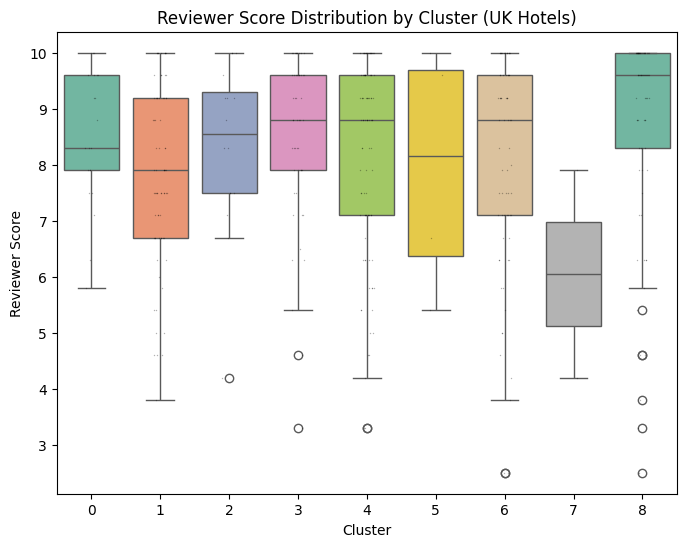

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 군집별 평점 요약 통계
score_summary = (
    Uk_hotels.groupby("Cluster")["Reviewer_Score"]
    .agg(["count","mean","std","min","max"])
    .reset_index()
    .sort_values("mean", ascending=False)
)
print(score_summary)

# 박스플롯 시각화
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Reviewer_Score", data=Uk_hotels, palette="Set2")
sns.stripplot(x="Cluster", y="Reviewer_Score", data=Uk_hotels,
              color="black", size=1, alpha=0.3)  # 분포 점찍기
plt.title("Reviewer Score Distribution by Cluster (UK Hotels)")
plt.ylabel("Reviewer Score")
plt.show()


          Reviewer_Nationality  count      mean       std  min   max
46             United Kingdom     215  8.059535  1.806631  2.5  10.0
47   United States of America      44  8.609091  1.489938  4.6  10.0
0                   Australia      19  8.036842  1.661061  4.2  10.0
45       United Arab Emirates      12  8.808333  1.448798  5.4  10.0
17                    Ireland       9  8.477778  1.356261  6.3  10.0
5                      Canada       9  8.522222  1.795674  5.8  10.0
22                     Kuwait       6  7.600000  2.288231  3.3   9.2
38               South Africa       6  8.833333  1.187715  6.7  10.0
42                Switzerland       5  7.180000  1.725399  5.4  10.0
26                New Zealand       5  9.600000  0.282843  9.2  10.0


/tmp/ipython-input-2403053948.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Reviewer_Nationality", y="Reviewer_Score",


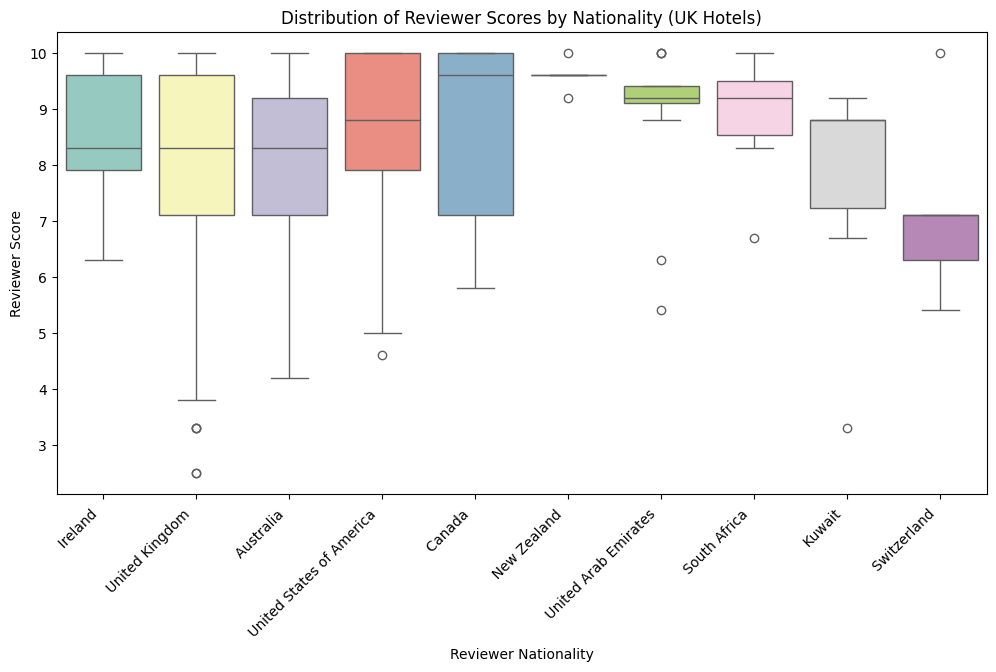

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 리뷰어 국적별 요약 통계
nation_summary = (
    Uk_hotels.groupby("Reviewer_Nationality")["Reviewer_Score"]
    .agg(["count","mean","std","min","max"])
    .reset_index()
    .sort_values("count", ascending=False)
)

print(nation_summary.head(10))  # 리뷰 많은 상위 10개 국적

# 2) 상위 국적별 분포 시각화 (상위 10개만 예시)
top_nations = nation_summary.head(10)["Reviewer_Nationality"]

plt.figure(figsize=(12,6))
sns.boxplot(x="Reviewer_Nationality", y="Reviewer_Score",
            data=Uk_hotels[Uk_hotels["Reviewer_Nationality"].isin(top_nations)],
            palette="Set3")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Reviewer Scores by Nationality (UK Hotels)")
plt.ylabel("Reviewer Score")
plt.xlabel("Reviewer Nationality")
plt.show()


In [38]:
# 군집 × 국적별 리뷰 통계 요약
cluster_nation_summary = (
    Uk_hotels.groupby(["Cluster","Reviewer_Nationality"])["Reviewer_Score"]
    .agg(
        count="size",        # 리뷰 수
        mean="mean",         # 평균 점수
        std="std"            # 표준편차
    )
    .reset_index()
    .sort_values(["Cluster","count"], ascending=[True,False])
)

# 👉 원하는 군집만 필터링 (예: 군집 0)
cluster_id = 0
cluster_subset = cluster_nation_summary.query("Cluster == @cluster_id")

# 리뷰가 많은 순 상위 20개 출력
print(cluster_subset.head(20))


   Cluster        Reviewer_Nationality  count       mean       std
3        0             United Kingdom      17   8.411765  1.257916
0        0             Czech Republic       1  10.000000       NaN
1        0                    Ireland       1   8.300000       NaN
2        0               South Africa       1   9.600000       NaN
4        0   United States of America       1   7.500000       NaN


In [39]:
# 군집 × 국적별 리뷰 통계 요약
cluster_nation_summary = (
    Uk_hotels.groupby(["Cluster","Reviewer_Nationality"])["Reviewer_Score"]
    .agg(
        count="size",        # 리뷰 수
        mean="mean",         # 평균 점수
        std="std"            # 표준편차
    )
    .reset_index()
    .sort_values(["Cluster","count"], ascending=[True,False])
)

# 👉 원하는 군집만 필터링 (예: 군집 0)
cluster_id = 1
cluster_subset = cluster_nation_summary.query("Cluster == @cluster_id")

# 리뷰가 많은 순 상위 20개 출력
print(cluster_subset.head(20))


    Cluster        Reviewer_Nationality  count       mean       std
27        1             United Kingdom      28   7.528571  1.524092
28        1   United States of America      10   7.430000  1.928183
26        1       United Arab Emirates       5   8.600000  1.822087
5         1                  Australia       3   7.933333  1.115049
14        1                     Kuwait       3   8.233333  1.342882
6         1                     Brazil       2   9.800000  0.282843
7         1                      China       2   8.350000  2.333452
12        1                     Israel       2   8.950000  1.484924
19        1                   Portugal       2   8.550000  0.919239
24        1                     Sweden       2   7.700000  0.282843
8         1                     Cyprus       1   8.300000       NaN
9         1                    Germany       1   6.300000       NaN
10        1                  Hong Kong       1   6.300000       NaN
11        1                    Ireland       1  

## 영국 군집1에 대한 견해

- 군집1은 영국 내 호텔 갯수가 상위2번째에 해당할 정도로 많음
- 이에 리뷰 작성수도 적지 않음에도 불구하고 호텔의 평균평점은 끝에서 두번째로 굉장히 낮음
    - 1위: 8.67(군집8) / 이때 군집 1은 7.83에 해당
- 실제 군집1에 해당하는 지역은 패딩턴, 하이드파크 위에 해당
    - 런던 시내 바로 위 부촌 동네로 치안 좋고 깔끔한 동네로 평가되는 곳
    - 런던 중심부보다는 다소 숙박비용도 저렴한 편으로 평가됨
- 이러한 입지조건에 위치한 호텔이 왜 평균 평점은 낮게 책정되는 지에 대한 판단 필요


## 영국) 군집1 호텔의 평점 통계 분석

**확인해 볼 사항
- 군집 1의 평균/중앙값/최댓값/최솟값 평점
- 6점 미만(부정적) 비율, 8점 초과(긍정적) 비율
- 평점이 낮은 호텔이 어디인지 (Hotel_Name 기준)


In [43]:
from sklearn.cluster import KMeans

# 군집 1만 필터링
cluster1 = Uk_hotels[Uk_hotels["Cluster"] == 1].copy()

# 통계 요약
score_summary = cluster1["Reviewer_Score"].describe()
neg_ratio = (cluster1["Reviewer_Score"] < 6.0).mean()
pos_ratio = (cluster1["Reviewer_Score"] > 8.0).mean()

print("군집 1 리뷰 요약:")
print(score_summary)
print(f"부정 리뷰 비율 (<6점): {neg_ratio:.2%}")
print(f"긍정 리뷰 비율 (>8점): {pos_ratio:.2%}")

# 호텔별 평균 평점 (하위 10개)
hotel_avg = (
    cluster1.groupby("Hotel_Name")["Reviewer_Score"]
    .agg(["mean", "count"])
    .sort_values("mean")
    .head(10)
)

print("\n평점 낮은 호텔 Top 10:")
print(hotel_avg)


군집 1 리뷰 요약:
count    73.000000
mean      7.832877
std       1.584127
min       3.800000
25%       6.700000
50%       7.900000
75%       9.200000
max      10.000000
Name: Reviewer_Score, dtype: float64
부정 리뷰 비율 (<6점): 12.33%
긍정 리뷰 비율 (>8점): 42.47%

평점 낮은 호텔 Top 10:
                                          mean  count
Hotel_Name                                           
The Montcalm Marble Arch                   3.8      1
Best Western Maitrise Hotel Edgware Road   4.6      1
Mercure London Paddington Hotel            4.6      1
Hotel La Place                             4.6      1
St George Hotel                            5.0      1
London Elizabeth Hotel                     5.0      1
Ten Manchester Street Hotel                5.4      1
Shaftesbury Premier London Paddington      5.4      1
Hilton London Paddington                   5.8      1
Park Grand London Lancaster Gate           6.0      1


## 영국) 군집1 호텔의 실제 리뷰 확인 / 부정&긍정 리뷰 뽑아보기


In [46]:
# 하위 10개 호텔 리스트 변수
low_score_hotels = hotel_avg.index.tolist()

In [48]:
# 각 호텔에서 리뷰 3개씩 뽑아옴(긍&부)
review_samples = (
    cluster1[cluster1["Hotel_Name"].isin(low_score_hotels)]
    .groupby("Hotel_Name")
    .apply(lambda x: x[["Reviewer_Score", "Negative_Review", "Positive_Review"]].sample(n=min(3, len(x)), random_state=42))
    .reset_index(drop=True)
)

print(review_samples)

   Reviewer_Score  \
0             4.6   
1             5.8   
2             4.6   
3             5.0   
4             4.6   
5             6.0   
6             5.4   
7             5.0   
8             5.4   
9             3.8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Negative_Review  \
0                                                                                                                                                      

/tmp/ipython-input-3085084170.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[["Reviewer_Score", "Negative_Review", "Positive_Review"]].sample(n=min(3, len(x)), random_state=42))


## 결과

- 주차공간 부족 > 벤츠나 다른 차량이 두자리를 차지함 > 10번 돌아야 겨우 주차
- 스파이용 제한 > 결제했는제 풀장, 사우나만 열려있고 나머지는 사용 불가능 > 이에 대한 안내 없음
- 직원안내 부족 > 직원이 안내한 내용과 다름
- 추가요금 폭탄 > 수영장, 와이파이 등 전부 별도 요금으로 결국 가격이 비싸짐
- 방 온도 > 너무 덥고 에어컨은 작동 안함, 창문 드라이버로 열어야 함
- 뷰 > 옆 건물 공사중이라 창밖이 지저분
- 접근성 > 주변 공사로 인해 접근 어려움 (소음은 아님)
- 엘리베이터 > 문 사이 간격 위험할 정도로 넓음
- 욕실상태 > 작동은 하지만, 욕실 상태가 좋지않음
- 호텔시설 노후화 > 전체적으로 오래됨, 침대 얇고 조잡, 리노베이션 필요
- 레스토링 음식 질 > 피자가 부실, 인도요리는 괜찮다고..(카레 맛있다고..한거..진실임)
- 와이파이 유료 > 2000년대 같은 유료 와이파이 시스템에 대한 불만

> 시설 노후화, 가격대비 불만족, 정보의 불일치(사전 고지되지 않은 조건), 주변 환경적 불편함(공사,주차 등)

---

## 프랑스 군집0에 대한 분석 필요

In [55]:
from sklearn.cluster import KMeans

# 군집 1만 필터링
cluster0 = fr_hotels[fr_hotels["Cluster"] == 0].copy()

# 통계 요약
score_summary = cluster0["Reviewer_Score"].describe()
neg_ratio = (cluster0["Reviewer_Score"] < 6.0).mean()
pos_ratio = (cluster0["Reviewer_Score"] > 8.0).mean()

print("군집 0 리뷰 요약:")
print(score_summary)
print(f"부정 리뷰 비율 (<6점): {neg_ratio:.2%}")
print(f"긍정 리뷰 비율 (>8점): {pos_ratio:.2%}")

# 호텔별 평균 평점 (하위 10개)
hotel_avg = (
    cluster0.groupby("Hotel_Name")["Reviewer_Score"]
    .agg(["mean", "count"])
    .sort_values("mean")
    .head(10)
)

print("\n평점 낮은 호텔 Top 10:")
print(hotel_avg)


군집 0 리뷰 요약:
count    139.000000
mean       8.083453
std        1.935803
min        2.500000
25%        7.100000
50%        8.800000
75%        9.600000
max       10.000000
Name: Reviewer_Score, dtype: float64
부정 리뷰 비율 (<6점): 16.55%
긍정 리뷰 비율 (>8점): 61.87%

평점 낮은 호텔 Top 10:
                                              mean  count
Hotel_Name                                               
Novotel Paris Centre Tour Eiffel               2.5      1
Majestic Hotel Spa                             2.9      1
Hyatt Regency Paris Etoile                     3.3      1
H tel Beauchamps                               3.8      1
Residence Du Roy                               3.8      1
XO Hotel                                       3.8      1
Warwick Paris Former Warwick Champs Elysees    3.8      1
Atala Champs Elys es                           4.2      1
Le Dokhan s a Tribute Portfolio Hotel          4.2      1
Novotel Paris 17                               4.2      1


In [56]:
# 하위 10개 호텔 리스트 변수
low_score_hotels = hotel_avg.index.tolist()

In [57]:
# 각 호텔에서 리뷰 3개씩 뽑아옴(긍&부)
review_samples = (
    cluster0[cluster0["Hotel_Name"].isin(low_score_hotels)]
    .groupby("Hotel_Name")
    .apply(lambda x: x[["Reviewer_Score", "Negative_Review", "Positive_Review"]].sample(n=min(3, len(x)), random_state=42))
    .reset_index(drop=True)
)

print(review_samples)

   Reviewer_Score  \
0             4.2   
1             3.8   
2             3.3   
3             4.2   
4             2.9   
5             4.2   
6             2.5   
7             3.8   
8             3.8   
9             3.8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Negative_Review  \
0                                                                                                                                                    

/tmp/ipython-input-1656623245.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[["Reviewer_Score", "Negative_Review", "Positive_Review"]].sample(n=min(3, len(x)), random_state=42))


## 결과

- 청소불량 + 직원 무례: 청소 상태가 좋지 않으며 수건 교체만 하고 세면대나 욕조 청소 안되어있음
- 방 크기가 작고 위생 불량: 방 너무 작고 이불에 먼지가 가득 & tv가 작고 욕실과 화장실이 별도 공간에 있음
- 호텔 레스토랑 운영시간 짧고 외부 음식 배달 시 별도 요금 받음
- 새벽 화재경보에 대한 대응 미흡
- 조식 장소 협소& 음식 간소함
- 객실에 기본적인 슬리퍼나 칫솔 같은 기본 어메니티의 부재
- 카드 결제 오류 반복 & 조작 의심
- 무능한 경영진: 가격대비 가치 하락
- 리노베이션 사전 안내 없음: 소음
- 룸서비스 부재
- 체크인 지연
- 짐 관련 서비스 부재
- 객실 서비스 & 전화기 작동 안함

